# No-Wikidata

In [2]:
# Import
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import torch
import seaborn as sns
import matplotlib.pyplot as plt


# Carica dataset
ds = load_dataset("sapienzanlp/nlp2025_hw1_cultural_dataset")
train_df = pd.DataFrame(ds["train"])
val_df = pd.DataFrame(ds["validation"])

# Preprocessing
train_df = train_df.dropna(subset=["name", "description", "label"])
val_df = val_df.dropna(subset=["name", "description", "label"])
train_df["text"] = train_df["name"] + " " + train_df["description"]
val_df["text"] = val_df["name"] + " " + val_df["description"]

# Encoding delle label
label_enc = LabelEncoder()
train_df["label_encoded"] = label_enc.fit_transform(train_df["label"])
val_df["label_encoded"] = label_enc.transform(val_df["label"])

# Conversione in Dataset HuggingFace
train_dataset = Dataset.from_pandas(train_df[["text", "label_encoded"]].rename(columns={"label_encoded": "label"}))
val_dataset = Dataset.from_pandas(val_df[["text", "label_encoded"]].rename(columns={"label_encoded": "label"}))


# Tokenizer e modello
model_name = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Tokenizzazione
def tokenize(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

train_dataset = train_dataset.remove_columns(["text"])
val_dataset = val_dataset.remove_columns(["text"])
train_dataset.set_format("torch")
val_dataset.set_format("torch")

# Funzione di calcolo delle metriche, inclusa la confusion matrix
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    
    # Calcola la confusion matrix
    cm = confusion_matrix(labels, preds)
    
    # Visualizzazione della confusion matrix con Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_enc.classes_, yticklabels=label_enc.classes_)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Calcola le metriche di classificazione
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
        "f1": f1_score(labels, preds, average="macro"),
    }

# Parametri di training
training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_steps=10,
    save_steps=100,
    eval_steps=100,
)


# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Allenamento
trainer.train()
trainer.save_model("lm_cultural_classifier")

def predict(df, output_path):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    with torch.no_grad():
        inputs = tokenizer(df["text"].tolist(), padding=True, truncation=True, return_tensors="pt")
        # Sposta tutto su GPU o CPU coerentemente
        inputs = {key: val.to(device) for key, val in inputs.items()}

        outputs = model(**inputs)
        preds = outputs.logits.argmax(axis=1).detach().cpu().numpy()

    df["classification"] = label_enc.inverse_transform(preds)
    df[[ "name", "description", "type", "category", "label"]].to_csv(output_path, index=False)

# Esegui predizione (decommenta per test)
predict(val_df, "dev_predictions.csv")
#Confusion Matrix
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

with torch.no_grad():
    inputs = tokenizer(val_df["text"].tolist(), padding=True, truncation=True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model(**inputs)
    preds = outputs.logits.argmax(dim=1).detach().cpu().numpy()
    val_df["classification"] = label_enc.inverse_transform(preds)


def plot_confusion_matrix(df):
    y_true = df["label"]
    y_pred = df["classification"]

    # Crea la confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=label_enc.classes_)
    
    # Visualizza la confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_enc.classes_)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

# Dopo aver eseguito la predizione
val_df["classification"] = label_enc.inverse_transform(
    model(
        **{k: v.to(device) for k, v in tokenizer(val_df["text"].tolist(), padding=True, truncation=True, return_tensors="pt").items()}
    ).logits.argmax(dim=1).detach().cpu().numpy()
)
plot_confusion_matrix(val_df)
from sklearn.metrics import classification_report

print(classification_report(val_df["label"], val_df["classification"], target_names=label_enc.classes_))


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6251 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Step,Training Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 96.00 MiB. GPU 0 has a total capacity of 3.60 GiB of which 19.31 MiB is free. Including non-PyTorch memory, this process has 3.56 GiB memory in use. Of the allocated memory 3.33 GiB is allocated by PyTorch, and 140.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# WIKIDATA

## Imports

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import time
from tqdm import tqdm

## Functions

In [4]:
def handle_get_request(entities_list, labeled):
    batch_size = 40
    url_base = "https://www.wikidata.org/w/api.php"
    results = {}
    total_batches = (len(entities_list) + batch_size - 1) // batch_size

    with tqdm(total=total_batches, desc=f"Scaricando batch di entità {labeled}") as pbar:
        for i in range(0, len(entities_list), batch_size):
            batch = entities_list[i:i + batch_size]
            ids_string = "|".join(batch)
            params = {
                "action": "wbgetentities",
                "ids": ids_string,
                "format": "json"
            }
            attempt = 0
            success = False
            while not success and attempt < 3:
                try:
                    response = requests.get(url_base, params=params, timeout=20)
                    response.raise_for_status()
                    data = response.json()
                    entities = data.get("entities", {})
                    for entity_id, entity_data in entities.items():
                        claims = entity_data.get("claims", {})
                        results[entity_id] = claims
                    success = True
                except requests.exceptions.RequestException as e:
                    print(f"Errore batch {batch}: {e}", flush=True)
                    wait_time = 2 ** attempt
                    print(f"Retry waiting {wait_time}s...", flush=True)
                    time.sleep(wait_time)
                    attempt += 1
            pbar.update(1)
    return results

def enrich_with_wikidata(df, label=""):
    df = df.copy()
    df["entity_id"] = df["item"].apply(lambda x: x.split("/")[-1])
    entity_ids = df["entity_id"].tolist()

    claims_dict = handle_get_request(entity_ids, labeled=label)

    countries = []
    for eid in df["entity_id"]:
        claims = claims_dict.get(eid, {})
        country = ""
        if "P17" in claims:
            try:
                mainsnak = claims["P17"][0].get("mainsnak", {})
                datavalue = mainsnak.get("datavalue", {})
                value = datavalue.get("value", {})
                country_id = value.get("id", "")
                country = country_id  # e.g., Q38
            except Exception as e:
                pass
        countries.append(country)

    df["country"] = countries
    return df.drop(columns=["entity_id"])

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_enc.classes_, yticklabels=label_enc.classes_)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
        "f1": f1_score(labels, preds, average="macro"),
    }

def predict(df, output_path):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    with torch.no_grad():
        inputs = tokenizer(df["text"].tolist(), padding=True, truncation=True, return_tensors="pt")
        inputs = {key: val.to(device) for key, val in inputs.items()}
        outputs = model(**inputs)
        preds = outputs.logits.argmax(axis=1).detach().cpu().numpy()
    df["classification"] = label_enc.inverse_transform(preds)
    df[["name", "description", "label","country","classification"]].to_csv(output_path, index=False)

def plot_confusion_matrix(df):
    y_true = df["label"]
    y_pred = df["classification"]
    cm = confusion_matrix(y_true, y_pred, labels=label_enc.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_enc.classes_)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()


## Load Dataset

In [5]:
ds = load_dataset("sapienzanlp/nlp2025_hw1_cultural_dataset")
train_df = pd.DataFrame(ds["train"])
val_df = pd.DataFrame(ds["validation"])

## Dataset Enrichment

In [ ]:
train_df = enrich_with_wikidata(train_df, label="train")
val_df = enrich_with_wikidata(val_df, label="val")

Scaricando batch di entità train:  59%|█████▊    | 92/157 [02:03<01:35,  1.47s/it]

## Tokenizer and Model

In [ ]:
model_name = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
print(model.config.hidden_size)
def tokenize(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

NameError: name 'AutoTokenizer' is not defined

## Dataset Manipulation

In [ ]:
def build_text(df):
    return df["name"] + " " + df["description"] + " " + df["country"] #+ " " + df["instance_of"] #+ " " + df["industry"]

train_df = train_df.dropna(subset=["name", "description", "label"])
val_df = val_df.dropna(subset=["name", "description", "label"])
train_df["text"] = build_text(train_df)
val_df["text"] = build_text(val_df)
#Label Encoding
label_enc = LabelEncoder()
train_df["label_encoded"] = label_enc.fit_transform(train_df["label"])
val_df["label_encoded"] = label_enc.transform(val_df["label"])
# Conversione in Dataset HuggingFace
train_dataset = Dataset.from_pandas(train_df[["text", "label_encoded"]].rename(columns={"label_encoded": "label"}))
val_dataset = Dataset.from_pandas(val_df[["text", "label_encoded"]].rename(columns={"label_encoded": "label"}))

In [ ]:
# Tokenizzazione


train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
train_dataset = train_dataset.remove_columns(["text"])
val_dataset = val_dataset.remove_columns(["text"])
train_dataset.set_format("torch")
val_dataset.set_format("torch")

Map:   0%|          | 0/6251 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

## Training

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir='./logs', 
    logging_steps=10,
    save_steps=100,
    eval_steps=100,
    disable_tqdm=False  
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)
trainer.train()
trainer.save_model("lm_cultural_classifier")

Step,Training Loss
10,1.063800
20,1.043500
30,0.904700
40,0.799300
50,0.703500
60,0.735900
70,0.696900
80,0.717800
90,0.600600
100,0.625900


## Predictions

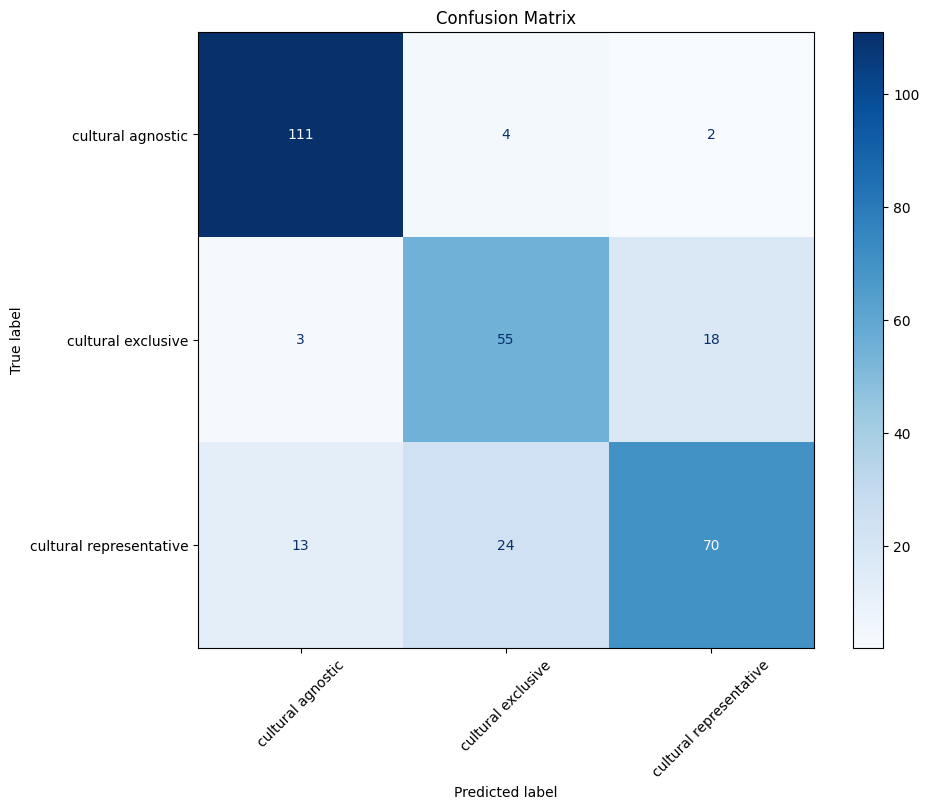

                         precision    recall  f1-score   support

      cultural agnostic       0.87      0.95      0.91       117
     cultural exclusive       0.66      0.72      0.69        76
cultural representative       0.78      0.65      0.71       107

               accuracy                           0.79       300
              macro avg       0.77      0.78      0.77       300
           weighted avg       0.79      0.79      0.78       300



In [ ]:

predict(val_df, "dev_predictions.csv")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
val_inputs = tokenizer(val_df["text"].tolist(), padding=True, truncation=True, return_tensors="pt")
val_inputs = {k: v.to(device) for k, v in val_inputs.items()}
with torch.no_grad():
    val_outputs = model(**val_inputs)
    val_preds = val_outputs.logits.argmax(dim=1).detach().cpu().numpy()
val_df["classification"] = label_enc.inverse_transform(val_preds)
plot_confusion_matrix(val_df)
print(classification_report(val_df["label"], val_df["classification"], target_names=label_enc.classes_))